In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import library

In [ ]:
!pip install transformers datasets peft evaluate scikit-learn matplotlib torch --quiet

import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, TaskType
import unicodedata
import re
import torch.nn as nn

### Load Dataset

In [ ]:
data_path = "/content/drive/MyDrive/Khmer_Sentimental_Analysis/kh_sentimental_data_cleaned_V2.csv"  # change path
df = pd.read_csv(data_path)

### Text Preprocessing

In [ ]:
def preprocess_khmer_for_xlmr(text):
    """
    SAFE preprocessing for XLM-RoBERTa with Khmer text
    Only fixes what's necessary, doesn't change tokenization
    """
    if pd.isna(text):
        return ""

    # 1. Convert to string
    text = str(text)

    # 2. Unicode normalization (MUST DO for Khmer)
    text = unicodedata.normalize('NFC', text)

    # 3. Remove invisible characters that break tokenization
    text = text.replace('\u200B', '')  # Zero-width space
    text = text.replace('\uFEFF', '')  # Byte Order Mark (BOM)

    # 4. Convert non-breaking space to normal space
    text = text.replace('\u00A0', ' ')

    # 5. Trim extra whitespace from edges ONLY
    text = text.strip()

    return text

# 2. Apply preprocessing (change 'text' to your column name)
df['text'] = df['text'].apply(preprocess_khmer_for_xlmr)

# 3. Remove completely empty texts
df = df[df['text'] != '']

# # 4. Quick check
# print("First 3 rows - Before vs After:")
# for i in range(min(3, len(df))):
#     print(f"\nRow {i}:")
#     print(f"BEFORE: {repr(df['text'].iloc[i])[:80]}")
#     print(f"AFTER:  {repr(df['text'].iloc[i])[:80]}")

### Analyze the token lengths

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1643 > 512). Running this sequence through the model will result in indexing errors


count    22420.000000
mean        62.847770
std         52.959434
min          2.000000
25%         25.000000
50%         48.000000
75%         88.000000
max       2687.000000
Name: num_tokens, dtype: float64


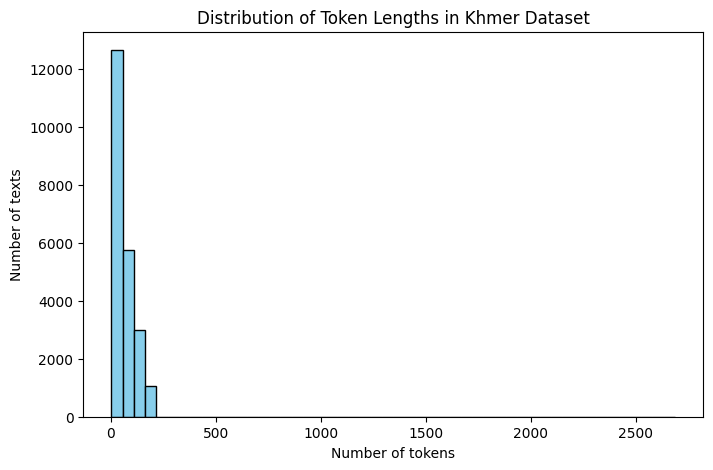

Suggested max_length (95th percentile): 163


In [ ]:
# Load tokenizer
model_name = "songhieng/khmer-xlmr-base-sentimental-multi-label"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Compute token length for each text
df['num_tokens'] = df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

# Display basic stats
print(df['num_tokens'].describe())

# Plot histogram of token lengths
plt.figure(figsize=(8,5))
plt.hist(df['num_tokens'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Number of tokens")
plt.ylabel("Number of texts")
plt.title("Distribution of Token Lengths in Khmer Dataset")
plt.show()

# Optional: find 95th percentile as a safe max_length
max_len_95 = int(df['num_tokens'].quantile(0.95))
print(f"Suggested max_length (95th percentile): {max_len_95}")

### Split dataset: 80% train, 10% val, 10% test

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

In [ ]:
# Save splits to Drive
split_dir = "/content/drive/MyDrive/Khmer_Sentimental_Analysis"
os.makedirs(split_dir, exist_ok=True)
train_df.to_csv(os.path.join(split_dir, "train.csv"), index=False)
val_df.to_csv(os.path.join(split_dir, "val.csv"), index=False)
test_df.to_csv(os.path.join(split_dir, "test.csv"), index=False)

In [ ]:
# Get training labels as numpy array
train_labels = train_df["label"].values

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1, 2]),
    y=train_labels
)

# Convert to torch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Raw class weights:", class_weights)

# NORMALIZE: Scale max weight to 3.0
raw_weights = class_weights.clone()  # Keep original
class_weights = class_weights / class_weights.max() * 3.0
print(f"Normalized weights (max=3.0): {class_weights}")

Raw class weights: tensor([0.8153, 0.6226, 5.9787])
Normalized weights (max=3.0): tensor([0.4091, 0.3124, 3.0000])


In [ ]:
# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

### Tokenization

In [ ]:
model_name = "FacebookAI/xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/17936 [00:00<?, ? examples/s]

Map:   0%|          | 0/2242 [00:00<?, ? examples/s]

Map:   0%|          | 0/2242 [00:00<?, ? examples/s]

### Load model + configure LoRA

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, problem_type="single_label_classification")

# Print total parameters (before LoRA)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters (before LoRA): {total_params}")

# LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8, #8, 4
    lora_alpha=16, #16, 8
    lora_dropout=0.12, #0.1, 0.2, 0.1, 0.15
    target_modules=["query", "value"]
)
model = get_peft_model(model, lora_config)

# Print trainable parameters after LoRA
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters (after LoRA): {trainable_params}")

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model is on device: {device}")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters (before LoRA): 278045955
Trainable parameters (after LoRA): 887811
Model is on device: cuda


### Define metrics for evaluation

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro", zero_division=0)
    recall = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)

    # Optional ROC-AUC (One-vs-Rest)
    roc_auc = None
    try:
        from sklearn.preprocessing import label_binarize
        labels_bin = label_binarize(labels, classes=[0,1,2])
        probs = torch.softmax(torch.tensor(pred.predictions), dim=1).numpy()
        aucs = []
        for i in range(labels_bin.shape[1]):
            fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
            aucs.append(auc(fpr, tpr))
        roc_auc = sum(aucs)/len(aucs)
    except:
        roc_auc = None

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1_macro": f1, "roc_auc": roc_auc}

### Training arguments

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Khmer_Sentimental_Analysis/Ex6",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=15, #10, 15, 10
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5, #2r-5, 1e-5
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    weight_decay=0.02, #0.01, 0.03
    save_total_limit=3,
    logging_dir="/content/logs",
    logging_steps=50,
    logging_strategy="steps",
    warmup_ratio=0.1,   # optional
    fp16=True,          # optional
    report_to=["tensorboard"]
)

### Trainer

In [ ]:
from transformers import Trainer, EarlyStoppingCallback
import torch.nn as nn

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Don't move to device here - do it in compute_loss
        self.class_weights = class_weights  # Keep as tensor

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Move weights to same device as model
        weights = self.class_weights.to(logits.device)

        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
# Use WeightedTrainer
trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if val doesn't improve for 3 evals
)


/tmp/ipython-input-3426264296.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


### Train model

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro,Roc Auc
1,1.020200,0.974068,0.526316,0.453322,0.442413,0.422105,0.702733
2,0.841700,0.782668,0.734612,0.611785,0.658813,0.625076,0.858321
3,0.687400,0.654379,0.768956,0.661458,0.737379,0.683591,0.896488
4,0.672300,0.690017,0.793934,0.697801,0.736054,0.712817,0.910749
5,0.671500,0.638417,0.795272,0.703681,0.740658,0.717266,0.916428
6,0.664900,0.696260,0.807761,0.732210,0.730122,0.731033,0.920547
7,0.576400,0.617235,0.801517,0.711461,0.746328,0.725146,0.921754
8,0.639600,0.618761,0.801517,0.709533,0.751739,0.726988,0.922576


TrainOutput(global_step=8968, training_loss=0.7284172594706785, metrics={'train_runtime': 839.7695, 'train_samples_per_second': 320.374, 'train_steps_per_second': 20.023, 'total_flos': 9536240213360640.0, 'train_loss': 0.7284172594706785, 'epoch': 8.0})

In [ ]:
from peft import PeftModel

peft_model = trainer.model

print(isinstance(peft_model, PeftModel))  # MUST be True

True


In [ ]:
merged_model = peft_model.merge_and_unload()

# Sanity check (MUST be False)
any("lora" in k.lower() for k in merged_model.state_dict().keys())


False

In [ ]:
torch.save(
    merged_model.state_dict(),
    "/content/drive/MyDrive/Khmer_Sentimental_Analysis/Ex6/Ex6_best_model.pth"
)

### Evaluate on test set

In [ ]:
preds_output = trainer.predict(test_dataset)
test_metrics = compute_metrics(preds_output)

print("Test set metrics:", test_metrics)

Test set metrics: {'accuracy': 0.8180196253345228, 'precision': 0.7285737944477942, 'recall': 0.7134092451229855, 'f1_macro': 0.7203892840790554, 'roc_auc': np.float64(0.9205173209409697)}


In [ ]:
results_csv = os.path.join(training_args.output_dir, "Ex_6_evaluation_results.csv")

# Safely extract last training & validation loss
train_loss = next(
    x["loss"] for x in reversed(trainer.state.log_history) if "loss" in x
)

val_loss = next(
    x["eval_loss"] for x in reversed(trainer.state.log_history) if "eval_loss" in x
)

results_df = pd.DataFrame([{
    "Experiment": "Experiment_6",
    "epoch": trainer.state.epoch,  # actual best epoch (early stopping safe)
    "lr": training_args.learning_rate,
    "r": lora_config.r,
    "lora_alpha": lora_config.lora_alpha,
    "lora_dropout": lora_config.lora_dropout,
    "max_length": 128,
    "batch_size": training_args.per_device_train_batch_size,
    "warmup_ratio": training_args.warmup_ratio,
    "weight_decay": training_args.weight_decay,
    "training_loss": train_loss,
    "validation_loss": val_loss,
    "accuracy": test_metrics["accuracy"],
    "precision": test_metrics["precision"],
    "recall": test_metrics["recall"],
    "f1_macro": test_metrics["f1_macro"]
}])

results_df.to_csv(results_csv, index=False)

### Plot training & validation loss vs epoch

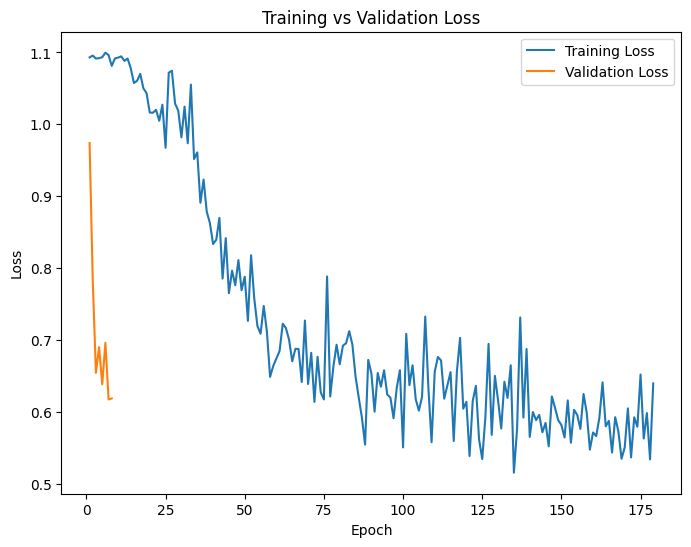

In [ ]:
log_history = trainer.state.log_history
train_losses = [x["loss"] for x in log_history if "loss" in x]
eval_losses = [x["eval_loss"] for x in log_history if "eval_loss" in x]

plt.figure(figsize=(8,6))
plt.plot(range(1,len(train_losses)+1), train_losses, label="Training Loss")
plt.plot(range(1,len(eval_losses)+1), eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Ex6)")
plt.legend()
plt.show()

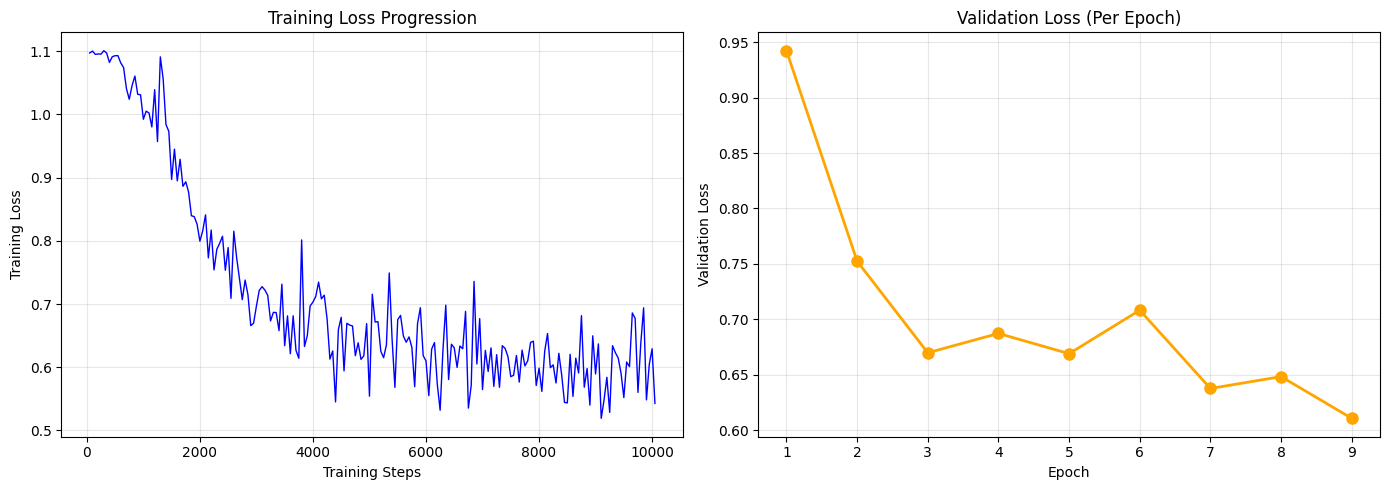

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training loss over steps
train_steps = [x.get("step", i) for i, x in enumerate(log_history) if "loss" in x and "eval_loss" not in x]
train_losses = [x["loss"] for x in log_history if "loss" in x and "eval_loss" not in x]
ax1.plot(train_steps, train_losses, color='blue', linewidth=1)
ax1.set_xlabel("Training Steps")
ax1.set_ylabel("Training Loss")
ax1.set_title("Training Loss Progression")
ax1.grid(True, alpha=0.3)

# Plot 2: Validation loss over epochs
eval_epochs = [x["epoch"] for x in log_history if "eval_loss" in x]
eval_losses = [x["eval_loss"] for x in log_history if "eval_loss" in x]
ax2.plot(eval_epochs, eval_losses, color='orange', marker='o', linewidth=2, markersize=8)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Validation Loss")
ax2.set_title("Validation Loss (Per Epoch)")
ax2.grid(True, alpha=0.3)
ax2.set_xticks(eval_epochs)  # Show each epoch

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Khmer_Sentimental_Analysis/Ex5/Ex5_trainingcurve.png")
plt.show()

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained(
    "FacebookAI/xlm-roberta-base",
    num_labels=3
)

state_dict = torch.load(
    "/content/drive/MyDrive/Khmer_Sentimental_Analysis/Ex5/Ex5_best_model.pth",
    map_location="cpu"
)

model.load_state_dict(state_dict)
model.eval()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ===============================================
# 4️⃣ Label mapping
# ===============================================
id2label = {
    0: "negative",
    1: "positive",
    2: "neutral"
}

# ===============================================
# 5️⃣ Text preprocessing (same as training)
# ===============================================
def preprocess_khmer_for_xlmr(text):
    text = str(text)
    text = unicodedata.normalize("NFC", text)
    text = text.replace("\u200B", "").replace("\uFEFF", "")
    text = text.replace("\u00A0", " ")
    return text.strip()

# ===============================================
# 6️⃣ Prediction function
# ===============================================
@torch.no_grad()
def predict_sentiment(text):
    text = preprocess_khmer_for_xlmr(text)

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=123
    ).to(device)

    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)[0]

    pred_id = torch.argmax(probs).item()

    return {
        "label": id2label[pred_id],
        "confidence": round(probs[pred_id].item(), 4),
        "probabilities": {
            id2label[i]: round(probs[i].item(), 4) for i in range(3)
        }
    }

# ===============================================
# 7️⃣ Test with sample text
# ===============================================
samples = [
    "សេវាកម្មនេះល្អណាស់ ខ្ញុំពិតជាពេញចិត្ត",
    "ផលិតផលនេះអាក្រក់ ហើយខ្ញុំមិនសប្បាយចិត្តទេ",
    "វាធម្មតា មិនល្អហើយក៏មិនអាក្រក់"
]

for text in samples:
    result = predict_sentiment(text)
    print(f"\nText: {text}")
    print(result)


Text: សេវាកម្មនេះល្អណាស់ ខ្ញុំពិតជាពេញចិត្ត
{'label': 'positive', 'confidence': 0.9832, 'probabilities': {'negative': 0.0166, 'positive': 0.9832, 'neutral': 0.0002}}

Text: ផលិតផលនេះអាក្រក់ ហើយខ្ញុំមិនសប្បាយចិត្តទេ
{'label': 'negative', 'confidence': 0.9306, 'probabilities': {'negative': 0.9306, 'positive': 0.0688, 'neutral': 0.0005}}

Text: វាធម្មតា មិនល្អហើយក៏មិនអាក្រក់
{'label': 'negative', 'confidence': 0.9346, 'probabilities': {'negative': 0.9346, 'positive': 0.0647, 'neutral': 0.0007}}
